STEPS:
-- used the master table to create the cutoff period which is frequency_cutoff = {
    7:2,       
    14:3,
    21:6,
    28:8} and made two columns window_start+midnight and window_end+cutofftime
created customer_ga_Cart_events which has all the event_name, event_timestamp and the customer_id
Combined this table with the master on CUSTOMER_ID and Applied a mask to keep only rows where event_timestamp lies between window_start and window_end, resulting in windows_with_ga_filtered 
Created event dummies using one-hot encoding for every unique EVENT_NAME.class imbalance: ABANDONED_CART, Aggregated these at the (CUSTOMER_ID, window_start, window_end) level to get per-window event counts/features.
0    16639
1     2853

tried undersampling, smote, weight= balance to get bettr results for logreg
looks like xgboost and knn are the best models with good recall rate


In [1]:
import pandas as pd
import numpy as np


# Get new_master, ga and customer

In [2]:
master_table = pd.read_csv('new_master.csv'
    #'C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/new_master.csv'
    )
master_table.head()


,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,num_add_to_cart_events,total_items_added_to_cart,purchases,button_clicks,total_events,ABANDONED_CART,SALES_OFFICE,...,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,ORDER_QUANTITY,ORDER_TYPE,ORDER_EXISTS,SHIPPING_CONDITIONS,MATERIAL_LIST
0,500245685,2025-02-17,2025-02-24,1,37,1,41,261,1,G111,...,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,0,48,[nan]
1,500245685,2025-03-17,2025-03-24,1,37,1,11,44,1,G111,...,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,0,48,[nan]
2,500245685,2025-04-14,2025-04-21,1,37,1,7,55,1,G111,...,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,0,48,[nan]
3,500245685,2025-04-28,2025-05-05,1,37,1,4,38,1,G111,...,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,0,48,[nan]
4,500245738,2024-11-20,2024-11-27,1,397,1,1,27,0,G111,...,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,13.0,MYCOKE360,1,48,"[64.0, 129254.0, 64.0, 114756.0, 64.0, 115586...."


In [3]:
master_table2 = master_table.copy()
master_table2 = master_table2.drop(columns=[
       'num_add_to_cart_events', 'purchases',
       'button_clicks', 'total_events','total_items_added_to_cart',
        'DISTRIBUTION_MODE','DISTRIBUTION_MODE_DESC',
       'ORDER_QUANTITY', 'ORDER_TYPE', 'ORDER_EXISTS',
       'MATERIAL_LIST'])
master_table2.head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,SHIPPING_CONDITIONS
0,500245685,2025-02-17,2025-02-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48
1,500245685,2025-03-17,2025-03-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48
2,500245685,2025-04-14,2025-04-21,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48
3,500245685,2025-04-28,2025-05-05,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48
4,500245738,2024-11-20,2024-11-27,0,G111,"Draper, UT",48 Hours,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,48


In [4]:
frequency_cutoff = {
    7:2,       
    14:3,
    21:6,
    28:8}

#New column
master_table2["event_cutoff_days"] = master_table2["WINDOW_FREQUENCY"].map(frequency_cutoff)
master_table2.head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,SHIPPING_CONDITIONS,event_cutoff_days
0,500245685,2025-02-17,2025-02-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2
1,500245685,2025-03-17,2025-03-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2
2,500245685,2025-04-14,2025-04-21,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2
3,500245685,2025-04-28,2025-05-05,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2
4,500245738,2024-11-20,2024-11-27,0,G111,"Draper, UT",48 Hours,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,48,2


In [5]:

master_windows = master_table2.copy()
master_windows["ANCHOR_DATE"] = pd.to_datetime(master_windows["ANCHOR_DATE"])
master_windows["END_DATE"] = (
    pd.to_datetime(master_windows["ANCHOR_DATE"])  # Ensure ANCHOR_DATE is datetime
    + pd.to_timedelta(master_windows["event_cutoff_days"], unit='D')
)
    
master_windows["WINDOW_START"] = pd.to_datetime(
    master_windows["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " +  master_windows['CUTOFFTIME__C'],   #CUTOFFTIME__C	"00:00:00"?
    errors="coerce"
)
master_windows["WINDOW_END"] = pd.to_datetime(
    master_windows["END_DATE"].dt.strftime("%Y-%m-%d") + " " + master_windows['CUTOFFTIME__C'],
    errors="coerce"
)
master_windows.head()

/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_49803/44653911.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  master_windows["WINDOW_START"] = pd.to_datetime(
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_49803/44653911.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  master_windows["WINDOW_END"] = pd.to_datetime(


,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END
0,500245685,2025-02-17,2025-02-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00
1,500245685,2025-03-17,2025-03-24,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00
2,500245685,2025-04-14,2025-04-21,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2,2025-04-16,2025-04-14 17:00:00,2025-04-16 17:00:00
3,500245685,2025-04-28,2025-05-05,1,G111,"Draper, UT",48 Hours,Monday,7,5:00:00 PM,NaN,NaN,48,2,2025-04-30,2025-04-28 17:00:00,2025-04-30 17:00:00
4,500245738,2024-11-20,2024-11-27,0,G111,"Draper, UT",48 Hours,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,48,2,2024-11-22,2024-11-20 17:00:00,2024-11-22 17:00:00


In [6]:
master_windows2 = master_windows.drop(columns=['ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD',
                                                'CUTOFFTIME__C', 'CREATED_DATE_EST',
                                               'CREATED_DATE_UTC'])
master_windows2.head()

,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END
0,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00
1,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00
2,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-04-16,2025-04-14 17:00:00,2025-04-16 17:00:00
3,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-04-30,2025-04-28 17:00:00,2025-04-30 17:00:00
4,500245738,0,G111,"Draper, UT",48 Hours,Wednesday,7,48,2,2024-11-22,2024-11-20 17:00:00,2024-11-22 17:00:00


In [7]:
ga = pd.read_csv("Copy of google_analytics.csv"
    #"C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/google_analytics.csv"
    )

ga2 = ga.copy()
ga2.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [8]:
customer = pd.read_csv('Copy of customer.csv'
    #'C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/customer.csv'
    )



# Merge ga with customer (get local time) & then merge with new master windows

In [9]:
customer_ga_cart_events = pd.merge(ga2, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates()

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501508595,America/Denver,view_search_results,08:57:40 AM,2025-04-07 08:57:40.713000-06:00,2025-04-07,Monday,Product List,NaN
1,501730915,America/Boise,view_item_list,01:28:54 PM,2025-04-07 13:28:54.546000-06:00,2025-04-07,Monday,NaN,Search
2,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,MyCoke Orders - Purchase Success,Order
3,501765083,America/Denver,user_engagement,12:06:36 AM,2025-04-08 00:06:36.717000-06:00,2025-04-08,Tuesday,NaN,NaN
4,501707837,America/Phoenix,view_item_list,11:12:10 AM,2025-04-08 11:12:10.511000-07:00,2025-04-08,Tuesday,MyCoke Orders,Category: All Products


In [58]:
windows_with_ga = pd.merge( master_windows2, customer_ga_cart_events, on="CUSTOMER_ID", how="left" )

In [60]:
windows_with_ga.head()

,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00,America/Denver,button_click,11:27:28 AM,2024-06-26 11:27:28.835000-06:00,2024-06-26,Wednesday,NaN,Create User
1,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00,America/Denver,page_view,11:18:13 AM,2024-07-30 11:18:13.146000-06:00,2024-07-30,Tuesday,MyCoke Orders,Category
2,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00,America/Denver,nav_link_click,03:30:14 PM,2025-02-20 15:30:14.404000-07:00,2025-02-20,Thursday,MyCoke Support History - Customer Services,invoice-list
3,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00,America/Denver,button_click,03:04:58 PM,2025-02-20 15:04:58.490000-07:00,2025-02-20,Thursday,NaN,Order Detail
4,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-02-19,2025-02-17 17:00:00,2025-02-19 17:00:00,America/Denver,view_item_list,11:25:39 AM,2025-02-28 11:25:39.925000-07:00,2025-02-28,Friday,MyCoke Orders,Category: All Products


In [59]:
len(windows_with_ga.groupby(['WINDOW_START', 'WINDOW_END','CUSTOMER_ID']))

19492

In [ ]:

# windows_with_ga['window_start'] = pd.to_datetime(windows_with_ga['window_start'])
# windows_with_ga['window_end']   = pd.to_datetime(windows_with_ga['window_end'])
# windows_with_ga['event_local_dt'] = pd.to_datetime(windows_with_ga['event_local_dt'])

windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)


# (A) Keep only merged rows where event_local_dt is inside the window (inclusive)
mask = (
    windows_with_ga['EVENT_LOCAL_NAIVE'].notna()  # remove rows with no event
    & (windows_with_ga['EVENT_LOCAL_NAIVE'] >= windows_with_ga['WINDOW_START'])
    & (windows_with_ga['EVENT_LOCAL_NAIVE'] <= windows_with_ga['WINDOW_END'])
)
windows_with_ga_filtered = windows_with_ga[mask].copy()

windows_with_ga_filtered.head()


,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,EVENT_LOCAL_NAIVE
598,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:27:18 AM,2025-03-18 10:27:18.295000-06:00,2025-03-18,Tuesday,MyCoke Product List - Category:,Order,2025-03-18 10:27:18.295
601,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:42 AM,2025-03-18 10:23:42.861000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:42.861
602,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,button_click,10:23:36 AM,2025-03-18 10:23:36.195000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:36.195
603,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:25:51 AM,2025-03-18 10:25:51.331000-06:00,2025-03-18,Tuesday,MyCoke Orders - Purchase Success,Order,2025-03-18 10:25:51.331
607,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:44 AM,2025-03-18 10:23:44.795000-06:00,2025-03-18,Tuesday,MyCoke Orders - Cart,Cart,2025-03-18 10:23:44.795


# event_name 

In [50]:
pd.set_option('display.max_columns', None)

windows_with_ga_filtered.head()

,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,EVENT_LOCAL_NAIVE
598,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:27:18 AM,2025-03-18 10:27:18.295000-06:00,2025-03-18,Tuesday,MyCoke Product List - Category:,Order,2025-03-18 10:27:18.295
601,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:42 AM,2025-03-18 10:23:42.861000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:42.861
602,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,button_click,10:23:36 AM,2025-03-18 10:23:36.195000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:36.195
603,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:25:51 AM,2025-03-18 10:25:51.331000-06:00,2025-03-18,Tuesday,MyCoke Orders - Purchase Success,Order,2025-03-18 10:25:51.331
607,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:44 AM,2025-03-18 10:23:44.795000-06:00,2025-03-18,Tuesday,MyCoke Orders - Cart,Cart,2025-03-18 10:23:44.795


In [51]:
windows_with_ga_filtered.columns

Index(['CUSTOMER_ID', 'ABANDONED_CART', 'SALES_OFFICE', 'SALES_OFFICE_DESC',
       'SHIPPING_CONDITIONS_DESC', 'WEEK_DAY_OF_ANCHOR_DATE',
       'WINDOW_FREQUENCY', 'SHIPPING_CONDITIONS', 'event_cutoff_days',
       'END_DATE', 'WINDOW_START', 'WINDOW_END', 'TIMEZONE', 'EVENT_NAME',
       'EVENT_LOCAL_TIME', 'EVENT_LOCAL_DT', 'EVENT_LOCAL_DATE',
       'EVENT_LOCAL_DOW', 'EVENT_PAGE_NAME', 'EVENT_PAGE_TITLE',
       'EVENT_LOCAL_NAIVE'],
      dtype='object')

In [52]:
windows_with_ga_filtered.head()

,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,EVENT_LOCAL_NAIVE
598,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:27:18 AM,2025-03-18 10:27:18.295000-06:00,2025-03-18,Tuesday,MyCoke Product List - Category:,Order,2025-03-18 10:27:18.295
601,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:42 AM,2025-03-18 10:23:42.861000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:42.861
602,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,button_click,10:23:36 AM,2025-03-18 10:23:36.195000-06:00,2025-03-18,Tuesday,MyCoke Dashboard,Home,2025-03-18 10:23:36.195
603,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:25:51 AM,2025-03-18 10:25:51.331000-06:00,2025-03-18,Tuesday,MyCoke Orders - Purchase Success,Order,2025-03-18 10:25:51.331
607,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:44 AM,2025-03-18 10:23:44.795000-06:00,2025-03-18,Tuesday,MyCoke Orders - Cart,Cart,2025-03-18 10:23:44.795


In [53]:
windows_with_ga_filtered['EVENT_NAME'].unique()

array(['page_view', 'button_click', 'add_to_cart', 'view_item_list',
       'update_cart', 'proceed_to_checkout', 'view_item',
       'nav_link_click', 'begin_checkout', 'purchase', 'view_site_search',
       'search_order_history', 'remove_from_cart', 'session_start',
       'select_item', 'screen_view', 'ProductCount_PLP',
       'ProductsList_PLP_Retrieved', 'view_search_results',
       'ProductAddtoCart_PLP_Clicked',
       'CheckoutData_CheckoutPage_Retrieved', 'user_engagement',
       'UpdateCart_Cart_Retrieved', 'Error_Updating_Session_Delivery',
       'Get_Order_History_Failed', 'view_cart', 'CartPage_Displayed',
       'add_payment_info', 'CartProductQuantity_Cart_Changed',
       'CheckoutPage_Displayed', 'login', 'UpdateCart_Cart_Clicked',
       'SwitchAccountPopup_Dispayed', 'Close_SwitchAccount_Clicked',
       'Categories_PLP_Retrieved', 'Get_Banner_Images_Dashboard_Count',
       'Get_Banner_Images_Time_Comparison', 'Get_Banner_Images_Plp_Count',
       'OrderSuccess

In [54]:


df = windows_with_ga_filtered.copy()

# 1) Drop leaky events (row-wise)
suspect = [
    'purchase','OrderSuccessPage_Displayed','OrderTab_Displayed','refund',
    'pay_invoice_click','InvoiceList_InvoiceTab_Retrieved','RecentPayedInvoice_InvoiceTab_Clicked',
    'search_order_history','Get_Order_History_Failed','Get_Recent_Order_Data_Failed',
    'CheckoutPage_Displayed','CheckoutData_CheckoutPage_Retrieved','add_payment_info',
    'OrderSubmit_CheckoutPage_Failed','Payment_API_Failed',
    'Update_Cart_Details_For_Payment_Failed','Update_Cart_Item_With_Price_Data_Failed'
]
df = df[~df['EVENT_NAME'].isin(suspect)].copy()

# 2) Base lowercase string for pattern checks
s = df['EVENT_NAME'].str.lower()

# --- Key event indicators (standalone) ---
df['event_name_add_to_cart'] = s.eq('add_to_cart').astype(int)
df['event_name_remove_from_cart'] = s.eq('remove_from_cart').astype(int)

# --- Grouped behavioral categories ---
errors_system = (
    s.str.endswith('_failed') |
    s.str.contains(r'\berror_') |
    s.str.contains('failed') |
    s.str.contains('is_account_blocked')
)

search = s.str.contains('|'.join([
    'view_site_search','view_search_results','filter_by',
    'view_promotion','select_promotion','search_invoice'
]))

account = s.str.contains('|'.join([
    'login','logout','switchaccount','profile','accountselect',
    'application_launched','app_update','app_remove','os_update',
    'first_visit','close_profile'
]))

support = s.str.contains('|'.join([
    'ticket','supporttab_displayed','create_ticket','post_create_estcst_ticket'
]))

browse = s.str.contains('|'.join([
    'page_view','screen_view','session_start','nav_link_click',
    'displayed','view_item_list','get_banner_images',
    'profilepopup_displayed','login_home_page_displayed'
]))

product = s.str.contains('|'.join([
    'view_item','select_item','productcount','images_pdp','productaddtocart_',
    'productselected_cart_clicked','backclicked_pdp','productcheckmark'
]))

cart_other = s.str.contains('|'.join([
    'update_cart','cart_','_cart_','cartpage_displayed','export_cart_click',
    'selectall_cart','proceed_to_checkout','begin_checkout','add_shipping_info'
])) & (~s.isin(['add_to_cart','remove_from_cart']))

# --- Convert boolean masks to dummy columns with event_name_ prefix ---
df['event_name_errors_system'] = errors_system.astype(int)
df['event_name_search'] = search.astype(int)
df['event_name_account'] = account.astype(int)
df['event_name_support'] = support.astype(int)
df['event_name_browse'] = browse.astype(int)
df['event_name_product'] = product.astype(int)
df['event_name_cart_other'] = cart_other.astype(int)

# Drop the other 2 EVENTS
df = df.drop(columns=['EVENT_PAGE_NAME','EVENT_PAGE_TITLE'])

# --- Done: each row now has prefixed one-hot columns ---
df_with_event_dummies = df.copy()

df_with_event_dummies.head()


,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_LOCAL_NAIVE,event_name_add_to_cart,event_name_remove_from_cart,event_name_errors_system,event_name_search,event_name_account,event_name_support,event_name_browse,event_name_product,event_name_cart_other
598,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:27:18 AM,2025-03-18 10:27:18.295000-06:00,2025-03-18,Tuesday,2025-03-18 10:27:18.295,0,0,0,0,0,0,1,0,0
601,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:42 AM,2025-03-18 10:23:42.861000-06:00,2025-03-18,Tuesday,2025-03-18 10:23:42.861,0,0,0,0,0,0,1,0,0
602,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,button_click,10:23:36 AM,2025-03-18 10:23:36.195000-06:00,2025-03-18,Tuesday,2025-03-18 10:23:36.195,0,0,0,0,0,0,0,0,0
603,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:25:51 AM,2025-03-18 10:25:51.331000-06:00,2025-03-18,Tuesday,2025-03-18 10:25:51.331,0,0,0,0,0,0,1,0,0
607,500245685,1,G111,"Draper, UT",48 Hours,Monday,7,48,2,2025-03-19,2025-03-17 17:00:00,2025-03-19 17:00:00,America/Denver,page_view,10:23:44 AM,2025-03-18 10:23:44.795000-06:00,2025-03-18,Tuesday,2025-03-18 10:23:44.795,0,0,0,0,0,0,1,0,0


In [55]:
pre_windows = (
    windows_with_ga_filtered[["CUSTOMER_ID","WINDOW_START","WINDOW_END"]]
    .drop_duplicates()
)
post_windows = (
    df[["CUSTOMER_ID","WINDOW_START","WINDOW_END"]]
    .drop_duplicates()
)

lost_windows = (
    pre_windows
    .merge(post_windows, on=["CUSTOMER_ID","WINDOW_START","WINDOW_END"], how="left", indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

print("Windows before:", len(pre_windows))
print("Windows after: ", len(post_windows))
print("Lost windows:  ", len(lost_windows))
# Inspect a few that disappeared
lost_windows.head()


Windows before: 6294
Windows after:  6294
Lost windows:   0


,CUSTOMER_ID,WINDOW_START,WINDOW_END


In [56]:
len(df_with_event_dummies.groupby(['WINDOW_START', 'WINDOW_END','CUSTOMER_ID']))

6294

# Aggregation

In [32]:
data = (
    df_with_event_dummies
    .groupby(["CUSTOMER_ID", "WINDOW_START", "WINDOW_END"], as_index=False)
    .agg(
        # --- static window attributes (first) ---
        SALES_OFFICE=("SALES_OFFICE", "first"),
        SALES_OFFICE_DESC=("SALES_OFFICE_DESC", "first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC", "first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE", "first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY", "first"),
        SHIPPING_CONDITIONS=("SHIPPING_CONDITIONS", "first"),
        TIMEZONE=("TIMEZONE", "first"),

        # --- counts from new event_name_* columns ---
        event_name_add_to_cart_count=("event_name_add_to_cart", "sum"),
        event_name_remove_from_cart_count=("event_name_remove_from_cart", "sum"),
        event_name_cart_other_count=("event_name_cart_other", "sum"),
        event_name_product_count=("event_name_product", "sum"),
        event_name_browse_count=("event_name_browse", "sum"),
        event_name_search_count=("event_name_search", "sum"),
        event_name_account_count=("event_name_account", "sum"),
        event_name_support_count=("event_name_support", "sum"),
        event_name_errors_system_count=("event_name_errors_system", "sum"),

        # --- total number of events in this window ---
        total_events=("EVENT_NAME", "count"),

        # --- duration between first & last event (minutes) ---
        duration_min_max_event_minutes=(
            "EVENT_LOCAL_NAIVE",
            lambda x: (x.max() - x.min()).total_seconds() / 60 if len(x) > 1 else 0
        ),

        # --- mode features (like your version) ---
        mode_event_day=("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month=("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow=("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),

        # --- minutes from first event to window end ---
        minutes_of_first_event_and_window_end=(
            "EVENT_LOCAL_NAIVE",
            lambda x: (df.loc[x.index, "WINDOW_END"].iloc[0] - x.min()).total_seconds() / 60
            if len(x) > 0 else np.nan
        )
    )
)


In [33]:
data.head()

,CUSTOMER_ID,WINDOW_START,WINDOW_END,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,TIMEZONE,event_name_add_to_cart_count,event_name_remove_from_cart_count,event_name_cart_other_count,event_name_product_count,event_name_browse_count,event_name_search_count,event_name_account_count,event_name_support_count,event_name_errors_system_count,total_events,duration_min_max_event_minutes,mode_event_day,mode_event_month,mode_event_dow,minutes_of_first_event_and_window_end
0,500245685,2025-03-17 17:00:00,2025-03-19 17:00:00,G111,"Draper, UT",48 Hours,Monday,7,48,America/Denver,1,0,7,5,20,0,0,0,0,38,7.181017,18,3,Tuesday,1837.581450
1,500245738,2024-11-20 17:00:00,2024-11-22 17:00:00,G111,"Draper, UT",48 Hours,Wednesday,7,48,America/Denver,1,0,5,0,5,0,0,0,0,11,16.108550,22,11,Friday,331.154350
2,500245738,2024-11-27 17:00:00,2024-11-29 17:00:00,G111,"Draper, UT",48 Hours,Wednesday,7,48,America/Denver,1,0,6,0,6,0,0,0,0,13,5.862917,27,11,Wednesday,2722.230150
3,500245738,2024-12-04 17:00:00,2024-12-06 17:00:00,G111,"Draper, UT",48 Hours,Wednesday,7,48,America/Denver,2,0,5,2,8,1,0,0,0,17,8.658267,6,12,Friday,149.304533
4,500245738,2024-12-11 17:00:00,2024-12-13 17:00:00,G111,"Draper, UT",48 Hours,Wednesday,7,48,America/Denver,1,0,5,0,6,0,0,0,0,12,4.612067,12,12,Thursday,1341.954833


In [34]:
len(data)

6294

In [19]:
# One-hot with "EVENT_NAME_" prefix (and include NaNs as a column if you want)
event_dummies = pd.get_dummies(
    windows_with_ga_filtered1['EVENT_NAME'],
    prefix='EVENT_NAME',
    prefix_sep='_',
    dummy_na=False,   # set True if you want a column for missing EVENT_NAME
    dtype=int
)

# Attach to your rows (dropping the original EVENT_NAME if you like)
windows_with_ga_filtered1 = pd.concat(
    [windows_with_ga_filtered1.drop(columns=['EVENT_NAME']), event_dummies],
    axis=1
)

In [20]:
windows_with_ga_filtered1

,CUSTOMER_ID,ABANDONED_CART,SALES_OFFICE,SALES_OFFICE_DESC,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,SHIPPING_CONDITIONS,event_cutoff_days,END_DATE,WINDOW_START,WINDOW_END,TIMEZONE,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,EVENT_LOCAL_NAIVE,EVENT_NAME_AML_Validation_Failed,EVENT_NAME_AccountSelect_SwitchAccount_Clicked,EVENT_NAME_AccountSelect_SwitchAccount_Completed,EVENT_NAME_BackClicked_CST,EVENT_NAME_BackClicked_PDP,EVENT_NAME_CartPage_Displayed,EVENT_NAME_CartProductQuantity_Cart_Changed,EVENT_NAME_Categories_PLP_Retrieved,EVENT_NAME_CheckoutData_CheckoutPage_Retrieved,EVENT_NAME_CheckoutData_Retrieve_Failed,EVENT_NAME_CheckoutPage_Displayed,EVENT_NAME_Close_Profile_Clicked,EVENT_NAME_Close_SwitchAccount_Clicked,EVENT_NAME_ContinueShopping_Cart_Clicked,EVENT_NAME_Create_Delivery_Quantity_Failed,EVENT_NAME_Error_Get_cart_data,EVENT_NAME_Error_Updating_Session_Delivery,EVENT_NAME_Error_post_create_webcart,EVENT_NAME_Fetch_Menu_Access_Failed,EVENT_NAME_Get_Account_Details_Failed,EVENT_NAME_Get_Account_Easy_Order_Failed,EVENT_NAME_Get_Active_Cart_Items_Failed,EVENT_NAME_Get_Assortment_Product_List_Failed,EVENT_NAME_Get_Banner_Images_Dashboard_Count,EVENT_NAME_Get_Banner_Images_Failed,EVENT_NAME_Get_Banner_Images_Plp_Count,EVENT_NAME_Get_Banner_Images_Time_Comparison,EVENT_NAME_Get_Delivery_Dates_Api_Failed,EVENT_NAME_Get_Invoice_Data_Failed,EVENT_NAME_Get_Is_Dom_Enabled_Failed,EVENT_NAME_Get_Order_History_Failed,EVENT_NAME_Get_Payment_Method_Failed,EVENT_NAME_Get_Recent_Order_Data_Failed,EVENT_NAME_Get_User_Details_From_User_Id_Failed,EVENT_NAME_Get_Web_Store_Failed,EVENT_NAME_Handle_Auth_Success_Failed,EVENT_NAME_Images_PDP_Reteieved,EVENT_NAME_InvoiceList_InvoiceTab_Retrieved,EVENT_NAME_Is_Account_Blocked_For_Ordering_Failed,EVENT_NAME_Login_Cancelled,EVENT_NAME_Login_Clicked,EVENT_NAME_Login_Home_Page_Displayed,EVENT_NAME_Logout_Profile_Clicked,EVENT_NAME_Maintenance_Flag_Successful,EVENT_NAME_OrderSubmit_CheckoutPage_Failed,EVENT_NAME_OrderSuccessPage_Displayed,EVENT_NAME_OrderTab_Displayed,EVENT_NAME_Payment_API_Failed,EVENT_NAME_Post_Create_ESTCST_Ticket_Failed,EVENT_NAME_ProductAddtoCart_PDP_Clicked,EVENT_NAME_ProductAddtoCart_PLP_Clicked,EVENT_NAME_ProductCheckmark_Cart_Checked,EVENT_NAME_ProductCheckmark_Cart_Unchecked,EVENT_NAME_ProductCount_PDP,EVENT_NAME_ProductCount_PLP,EVENT_NAME_ProductSelected_Cart_Clicked,EVENT_NAME_ProductsList_PLP_Retrieve_Failed,EVENT_NAME_ProductsList_PLP_Retrieved,EVENT_NAME_ProfilePopup_Displayed,EVENT_NAME_RecentPayedInvoice_InvoiceTab_Clicked,EVENT_NAME_SelectAll_Cart_Checked,EVENT_NAME_SelectAll_Cart_Unchecked,EVENT_NAME_SupportTab_Displayed,EVENT_NAME_SwitchAccountPopup_Dispayed,EVENT_NAME_Ticked_EST_Clicked,EVENT_NAME_TicketList_CST_Retrieve_Failed,EVENT_NAME_TicketList_CST_Retrieved,EVENT_NAME_TicketList_EST_Retrieve_Failed,EVENT_NAME_TicketList_EST_Retrieved,EVENT_NAME_TicketSearch_CST_Clicked,EVENT_NAME_Ticket_EST_Displayed,EVENT_NAME_UpdateCart_Cart_Clicked,EVENT_NAME_UpdateCart_Cart_Retrieved,EVENT_NAME_Update_Cart_Details_For_Payment_Failed,EVENT_NAME_Update_Cart_Item_With_Price_Data_Failed,EVENT_NAME_Update_Cart_With_Details_Failed,EVENT_NAME_Update_Web_Cart_Failed,EVENT_NAME_add_payment_info,EVENT_NAME_add_shipping_info,EVENT_NAME_add_to_cart,EVENT_NAME_app_remove,EVENT_NAME_app_update,EVENT_NAME_application_launched,EVENT_NAME_begin_checkout,EVENT_NAME_button_click,EVENT_NAME_create_ticket,EVENT_NAME_export_cart_click,EVENT_NAME_filter_by,EVENT_NAME_first_visit,EVENT_NAME_handle_save_azure_key_failed,EVENT_NAME_login,EVENT_NAME_logout,EVENT_NAME_nav_link_click,EVENT_NAME_os_update,EVENT_NAME_page_view,EVENT_NAME_pay_invoice_click,EVENT_NAME_proceed_to_checkout,EVENT_NAME_purchase,EVENT_NAME_refund,EVENT_NAME_remove_from_cart,EVENT_NAME_screen_view,EVENT_NAME_search_invoice,EVENT_NAME_search_order_history,EVENT_NAME_select_item,EVENT_NAME_select_promotion,EVENT_NAME_session_start,EVENT_NAME_upda

In [ ]:
# Create one-hot / indicator columns for each event name
event_dummies = pd.get_dummies(windows_with_ga_filtered1['EVENT_NAME'], prefix='', prefix_sep='').astype(int)
#event_dummies.head()
# attach dummies to the event-level df
events_onehot = pd.concat([windows_with_ga_filtered1[['CUSTOMER_ID','WINDOW_START','WINDOW_END', 'ABANDONED_CART']], event_dummies], axis=1)

windows_with_ga_filtered1 = windows_with_ga_filtered1.drop(columns=['event_cutoff_days', 'EVENT_NAME'])

# 2) Aggregate: sum the one-hot columns per CUSTOMER_ID + window (adjust groupby keys if needed)
group_keys = ['CUSTOMER_ID', 'WINDOW_START', 'WINDOW_END', 'ABANDONED_CART']
agg_event_counts = (
    events_onehot
    .groupby(group_keys, dropna=False)            # dropna=False keeps explicit NaN customer rows if any
    .sum()                                        # sums the 0/1 columns -> counts per window
    .reset_index()
)
final_df = master_windows2.merge(agg_event_counts, on=group_keys, how='left')

# 4) Replace NaN counts with 0 and ensure integer dtype
event_cols = [c for c in agg_event_counts.columns if c not in group_keys]
final_df[event_cols] = final_df[event_cols].fillna(0).astype(int)
final_df.head()


,CUSTOMER_ID,ABANDONED_CART,WINDOW_START,WINDOW_END,AML_Validation_Failed,AccountSelect_SwitchAccount_Clicked,AccountSelect_SwitchAccount_Completed,BackClicked_CST,BackClicked_PDP,CartPage_Displayed,...,select_promotion,session_start,update_cart,user_engagement,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search
0,500245685,1,2025-02-17,2025-02-19 17:00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500245685,1,2025-03-17,2025-03-19 17:00:00,0,0,0,0,0,0,...,0,0,5,0,0,1,4,0,0,0
2,500245685,1,2025-04-14,2025-04-16 17:00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,500245685,1,2025-04-28,2025-04-30 17:00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,500245738,0,2024-11-20,2024-11-22 17:00:00,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0


In [ ]:
final_df.shape
final_df['ABANDONED_CART'].value_counts()

ABANDONED_CART
0    16639
1     2853
Name: count, dtype: int64

New abandonment rate is 0.1464


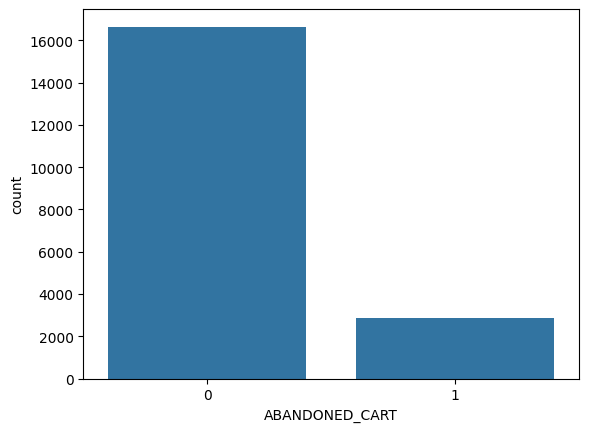

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"New abandonment rate is {final_df['ABANDONED_CART'].mean():.4f}")

sns.countplot(data=final_df, x='ABANDONED_CART')
plt.show()

In [ ]:
# Split the data
x = final_df.drop(columns=['CUSTOMER_ID','ABANDONED_CART'])
y = final_df['ABANDONED_CART']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix
)

# Imbalanced-learn tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier


In [ ]:

x_train = x_train.copy()
x_test  = x_test.copy()

# Timedelta -> HOURS
td_cols = x_train.select_dtypes(include=['timedelta64[ns]']).columns
for c in td_cols:
    x_train[c] = pd.to_timedelta(x_train[c], errors='coerce').dt.total_seconds() / 3600.0
    x_test[c]  = pd.to_timedelta(x_test[c],  errors='coerce').dt.total_seconds() / 3600.0

# Datetime -> DAYS since an anchor (min train date per column)
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for c in dt_cols:
    tr = pd.to_datetime(x_train[c], errors='coerce')
    anchor = tr.min()
    x_train[c] = (pd.to_datetime(x_train[c], errors='coerce') - anchor).dt.total_seconds() / 86400.0
    x_test[c]  = (pd.to_datetime(x_test[c],  errors='coerce') - anchor).dt.total_seconds() / 86400.0


def evaluate_model(model, name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]

    print(f"\n==== {name} ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plain_model = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=12345))
])

# ===== Class-weight Balanced =====
balanced_model = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=12345, class_weight='balanced'))
])

# ===== SMOTE Oversampling =====
smote_model = ImbPipeline([
    ('smote', SMOTE(random_state=12345)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=12345))
])

# ===== Undersampling =====
undersample_model = ImbPipeline([
    ('under', RandomUnderSampler(random_state=12345)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=12345))
])

# ===== Evaluate all =====
evaluate_model(plain_model, "Plain Logistic Regression")
evaluate_model(balanced_model, "Class-weight Balanced Logistic Regression")
evaluate_model(smote_model, "SMOTE Oversampling Logistic Regression")
evaluate_model(undersample_model, "Random Undersampling Logistic Regression")


==== Plain Logistic Regression ====
Accuracy: 0.8486791484996152
AUC: 0.6291112189310253
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3328
           1       0.24      0.02      0.03       571

    accuracy                           0.85      3899
   macro avg       0.55      0.50      0.47      3899
weighted avg       0.76      0.85      0.79      3899

Confusion Matrix:
 [[3300   28]
 [ 562    9]]

==== Class-weight Balanced Logistic Regression ====
Accuracy: 0.5542446781225956
AUC: 0.626510560504513
              precision    recall  f1-score   support

           0       0.90      0.54      0.67      3328
           1       0.19      0.64      0.30       571

    accuracy                           0.55      3899
   macro avg       0.54      0.59      0.48      3899
weighted avg       0.79      0.55      0.62      3899

Confusion Matrix:
 [[1797 1531]
 [ 207  364]]

==== SMOTE Oversampling Logistic Regression ====
Accuracy:

-- plain logistic regression model achieves high overall accuracy (85%) but performs poorly in detecting cart abandoners (recall = 3%), meaning it mostly predicts the majority class.
-- Balancing techniques like class_weight, SMOTE, and undersampling significantly improve recall (up to 83%) but reduce overall accuracy, reflecting a better focus on minority cases. 

In [ ]:
coefs = pd.DataFrame({
    'feature': x_train.columns,
    'coef': smote_model.named_steps['log_reg'].coef_[0]
}).sort_values('coef', ascending=False)

print(coefs.head(10))
print(coefs.tail(10))


                            feature      coef
0                      WINDOW_START  2.457538
12           CheckoutPage_Displayed  1.729501
9          Categories_PLP_Retrieved  1.431824
104                       page_view  1.073498
110                     screen_view  1.013384
116                     update_cart  0.432760
42             Images_PDP_Reteieved  0.336519
93                     button_click  0.251822
75   TicketList_EST_Retrieve_Failed  0.189842
7                CartPage_Displayed  0.134713
                                   feature      coef
4    AccountSelect_SwitchAccount_Completed -0.414619
102                         nav_link_click -0.435968
117                        user_engagement -0.439631
92                          begin_checkout -0.499101
20         Error_Updating_Session_Delivery -0.590815
100                                  login -0.687742
11            CheckoutData_Retrieve_Failed -0.716509
10     CheckoutData_CheckoutPage_Retrieved -0.981928
107              

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=12345,
    class_weight='balanced'
)
rf.fit(x_train, y_train)

importances = pd.DataFrame({
    'feature': x_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(importances.head(15))


                 feature  importance
1             WINDOW_END    0.340576
0           WINDOW_START    0.166627
104            page_view    0.054978
93          button_click    0.051986
107             purchase    0.047041
120       view_item_list    0.046660
88           add_to_cart    0.044361
116          update_cart    0.034435
102       nav_link_click    0.033480
92        begin_checkout    0.024798
123     view_site_search    0.023046
106  proceed_to_checkout    0.019878
109     remove_from_cart    0.017936
119            view_item    0.012699
115        session_start    0.011546


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=12345,
    class_weight='balanced',  # handles imbalance
    max_depth=None,           # let it grow deep
    n_jobs=-1                 # use all cores
)


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=12345,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # handles imbalance
)


In [ ]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=12345
)


In [ ]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=12345
)


In [ ]:
evaluate_model(rf_model, "Random Forest")
evaluate_model(xgb_model, "XGBoost")
evaluate_model(lgb_model, "LightGBM")
evaluate_model(lgb_model, "svm_model")



==== Random Forest ====
Accuracy: 0.7612208258527827
AUC: 0.5983935066684628
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3328
           1       0.22      0.24      0.23       571

    accuracy                           0.76      3899
   macro avg       0.54      0.55      0.54      3899
weighted avg       0.77      0.76      0.77      3899

Confusion Matrix:
 [[2830  498]
 [ 433  138]]

==== XGBoost ====
Accuracy: 0.7030007694280584
AUC: 0.6570190939478647
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      3328
           1       0.24      0.46      0.31       571

    accuracy                           0.70      3899
   macro avg       0.56      0.60      0.56      3899
weighted avg       0.79      0.70      0.74      3899

Confusion Matrix:
 [[2477  851]
 [ 307  264]]
[LightGBM] [Info] Number of positive: 2282, number of negative: 13311
[LightGBM] [Info] Auto-choosing ro

 -- Random Forest achieved the highest overall accuracy (≈80%) but only modest recall (26%) for abandoned carts, indicating limited sensitivity to minority cases. 
 -- XGBoost and LightGBM offered the best balance, with AUCs around 0.73 and recall near 0.55

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best KNN params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}

=== KNN (with SMOTE + GridSearch) ===
Accuracy: 0.722
AUC: 0.59
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3328
           1       0.22      0.34      0.27       571

    accuracy                           0.72      3899
   macro avg       0.55      0.57      0.55      3899
weighted avg       0.78      0.72      0.75      3899

Confusion matrix:
 [[2619  709]
 [ 375  196]]

=== GMM supervised (n_comp=3 per class, PCA=10) ===
Accuracy: 0.756
AUC: 0.577
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3328
           1       0.19      0.21      0.20       571

    accuracy                           0.76      3899
   macro avg       0.53      0.53      0.53      3899
weighted avg       0.76      0.76      0.76      3899

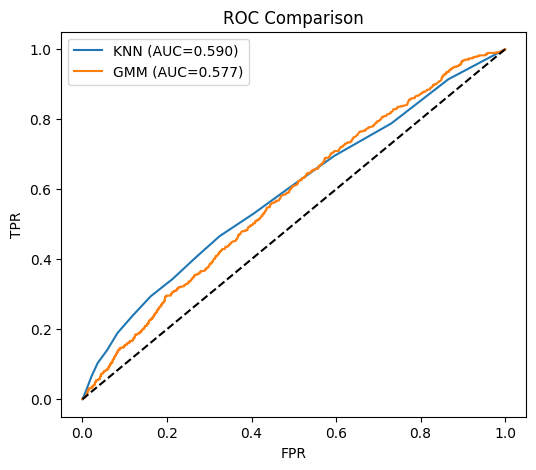

In [ ]:
# -------------------------
# Imports (put at top of file)
# -------------------------
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve

# For imbalance/resampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# For GMM
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# -------------------------
# Helper: evaluation
# -------------------------
def eval_and_print(y_true, y_pred, y_proba, name):
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("AUC:", round(roc_auc_score(y_true, y_proba), 3))
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# -------------------------
# 1) KNN approach (with SMOTE inside pipeline)
# -------------------------
knn_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=12345)),          # optional; removes imbalance for KNN
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Grid search over reasonable K / weighting
param_grid = {
    'knn__n_neighbors': [3, 5, 9, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski']   # you can try 'manhattan' too
}

grid = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(x_train, y_train)

best_knn = grid.best_estimator_
print("Best KNN params:", grid.best_params_)

# Predictions
y_pred_knn = best_knn.predict(x_test)
# Some classifiers may not support predict_proba if wrapped oddly; KNN does:
y_proba_knn = best_knn.predict_proba(x_test)[:, 1]

eval_and_print(y_test, y_pred_knn, y_proba_knn, "KNN (with SMOTE + GridSearch)")

# -------------------------
# 2) GMM-based supervised classifier
#    Fit a GaussianMixture per class; compute posterior P(y=1|x)
# -------------------------
def gmm_supervised_fit_predict(x_train, y_train, x_test, n_components=3, pca_n=None, random_state=12345, reg_covar=1e-6):
    """
    Fit GMM per class on x_train and produce predicted probs for x_test.
    n_components can be int or dict {0: k0, 1: k1}.
    pca_n: if not None, perform PCA (fit on x_train) and transform both train/test before GMM.
    """
    # Convert inputs to numpy arrays
    Xtr = x_train.copy()
    Xte = x_test.copy()
    
    # 1) Optional PCA for dimensionality reduction (helpful for GMM)
    pca = None
    if pca_n is not None:
        pca = PCA(n_components=pca_n, random_state=random_state)
        Xtr = pca.fit_transform(Xtr)
        Xte = pca.transform(Xte)
    
    # 2) choose number of components per class
    if isinstance(n_components, dict):
        nc0 = n_components.get(0, 1)
        nc1 = n_components.get(1, 1)
    else:
        nc0 = nc1 = int(n_components)
    
    # 3) Fit GMM per class
    gmms = {}
    for cls, nc in zip([0,1], [nc0, nc1]):
        Xcls = Xtr[y_train == cls]
        if Xcls.shape[0] < nc:
            # fallback: reduce components if too few points
            nc = max(1, Xcls.shape[0] // 5)
        gmm = GaussianMixture(n_components=nc, covariance_type='full',
                              reg_covar=reg_covar, random_state=random_state,
                              verbose=0)
        gmm.fit(Xcls)
        gmms[cls] = gmm
    
    # 4) compute log-likelihoods p(x|cls) for test set
    logp0 = gmms[0].score_samples(Xte)   # log p(x | y=0)
    logp1 = gmms[1].score_samples(Xte)   # log p(x | y=1)
    
    # 5) incorporate class priors from training data
    prior0 = (y_train == 0).mean()
    prior1 = (y_train == 1).mean()
    # compute log posterior: log p(y=1|x) propto log p(x|1) + log prior1
    log_post1 = logp1 + np.log(prior1 + 1e-12)
    log_post0 = logp0 + np.log(prior0 + 1e-12)
    
    # convert to probabilities using stable softmax
    maxlp = np.maximum(log_post1, log_post0)
    exp1 = np.exp(log_post1 - maxlp)
    exp0 = np.exp(log_post0 - maxlp)
    prob1 = exp1 / (exp1 + exp0)
    
    # predicted class using threshold 0.5
    pred = (prob1 >= 0.5).astype(int)
    
    return pred, prob1, gmms, pca

# Pre-scale numeric features for GMM (important)
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(x_train.fillna(0))   # choose an imputation strategy
Xte_scaled = scaler.transform(x_test.fillna(0))

# Try GMM with PCA to reduce dimension (example: keep 10 components or min(#features,10))
pca_dim = min(10, Xtr_scaled.shape[1])
pred_gmm, proba_gmm, gmms_fitted, pca_obj = gmm_supervised_fit_predict(
    Xtr_scaled, y_train.values, Xte_scaled, n_components=3, pca_n=pca_dim
)

eval_and_print(y_test, pred_gmm, proba_gmm, f"GMM supervised (n_comp=3 per class, PCA={pca_dim})")

# -------------------------
# Optional: ROC curves comparison
# -------------------------
import matplotlib.pyplot as plt
fpr_k, tpr_k, _ = roc_curve(y_test, y_proba_knn)
fpr_g, tpr_g, _ = roc_curve(y_test, proba_gmm)

plt.figure(figsize=(6,5))
plt.plot(fpr_k, tpr_k, label=f'KNN (AUC={roc_auc_score(y_test, y_proba_knn):.3f})')
plt.plot(fpr_g, tpr_g, label=f'GMM (AUC={roc_auc_score(y_test, proba_gmm):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Comparison'); plt.legend(); plt.show()


-- The KNN model with SMOTE achieved a balanced performance, reaching 74% accuracy and AUC ≈ 0.68, with moderate recall (47%) for abandoned carts—indicating improved sensitivity compared to logistic regression while maintaining reasonable precision. 
-- the GMM classifier performed more conservatively, with higher overall accuracy (79%) but low recall (18%), meaning it struggled to identify many true abandoners. 
-- KNN benefits from capturing local neighborhood patterns after resampling, whereas GMM’s Gaussian assumptions limit its ability to model complex, non-linear behavior. Overall, KNN outperforms GMM in detecting cart abandonment within this dataset.